# 1. Load dependencies

In [190]:
# Load dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as sns
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.base import clone 
from sklearn.model_selection import cross_val_score

# 2. Get Data

In [191]:
# Helper functions
def clean_cols(cols):
    cols_clean1 = cols.str.replace(' ', '_').str.replace('.', '')
    cols_clean2 = cols_clean1.str.replace('.', '') 
    cols_clean3 = [col.lower() for col in cols_clean2]
    return cols_clean3

In [192]:
# Get data from file path (downloaded from Kaggle)

file_path = "C:/Users/domen/github/pokemon_classification/datasets/Pokemon.csv"
df_raw = pd.read_csv(file_path)

# clean columns
df_raw.columns = clean_cols(df_raw.columns)

# convert columns with string values to lower
df_raw['type'] = df_raw.type.str.lower()
df_raw['other_type'] = df_raw.other_type.str.lower()
df_raw['name'] = df_raw.name.str.lower()


df_raw.head(3)

<ipython-input-191-b65e14a138b3>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  cols_clean1 = cols.str.replace(' ', '_').str.replace('.', '')
<ipython-input-191-b65e14a138b3>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  cols_clean2 = cols_clean1.str.replace('.', '')


,pokedex_no,name,type,other_type,hp,attack,defense,special_attack,special_defense,speed,total,generation,legendary
0,1,bulbasaur,grass,poison,45,49,49,65,65,45,318,1,0
1,2,ivysaur,grass,poison,60,62,63,80,80,60,405,1,0
2,3,venusaur,grass,poison,80,82,83,100,100,80,525,1,0


In [193]:
# View a summary of counts for the target variable (legendary)
print("-- pct")
print(df_raw.legendary.value_counts(normalize=True))
print("-- counts")
print(df_raw.legendary.value_counts())

-- pct
0    0.878469
1    0.121531
Name: legendary, dtype: float64
-- counts
0    918
1    127
Name: legendary, dtype: int64


In [194]:
# Feature engineering

df_raw[df_raw.legendary==True].sort_values(by = 'total', ascending = False).head()
#df.sort_values(by = 'total', ascending = False).head(100)

# create a feature for all "variant form pokemon" (mega, ultra, primal, etc.)
df_raw['variant_ind'] = np.where(df_raw.name.str.startswith(("mega ", "ultra ", "primal ")), 1,
                             np.where(df_raw.name.str.endswith(("eternamax", "10% forme", "50% forme")), 1, 0))

# create a feature for all "forme" pokemon
df_raw['forme_ind'] = np.where(df_raw.name.str.endswith(("forme")), 1, 0)

# create a string version with a prefix for generation num
df_raw[['generation_nm']] = 'gen_' + df_raw['generation'].astype(str)

# see some of those
df_raw.sort_values(by = 'total', ascending = False).head(3)
#df_raw[df_raw.name.str.contains('forme')].head(3)

,pokedex_no,name,type,other_type,hp,attack,defense,special_attack,special_defense,speed,total,generation,legendary,variant_ind,forme_ind,generation_nm
1033,890,eternatus eternamax,poison,dragon,255,115,250,125,250,130,1125,8,1,1,0,gen_8
464,384,mega rayquaza,dragon,flying,105,180,100,180,100,115,780,3,1,1,0,gen_3
195,150,mega mewtwo y,psychic,NaN,106,150,70,194,120,140,780,1,1,1,0,gen_1


# 3. Data Preparation

In [195]:
# Create dataframe for analysis
df = df_raw.copy()

# Create dummy variables
dummy_type1 = pd.get_dummies(df['type'], prefix='type1', drop_first=True)
dummy_type2 = pd.get_dummies(df['other_type'], prefix='type2', drop_first=True)

# Variables to drop
to_drop = ['pokedex_no', 'forme_ind', 'name', 'type', 'other_type', 'generation', 'generation_nm']
df.drop(to_drop, axis=1, inplace=True)

# Merge into a single data frame
merged = pd.concat([df, dummy_type1, dummy_type2], axis=1)

# Scale integer columns that have values greater than 1
#merged[["hp1", "attack1"]] = mms.fit_transform(merged[["hp", "attack"]]) # example
# cols_to_scale = [col for col in df.columns if df[col].max() > 1] # logic that should work but doesnt

cols_to_scale = ["hp", "attack", "defense", "special_attack", "special_defense", "speed", "total"]
mms = MinMaxScaler()
scaled = mms.fit_transform(merged[cols_to_scale])
scaled = pd.DataFrame(scaled, columns=cols_to_scale)

# Replace original columns with scaled ones
for col in scaled:
    merged[col] = scaled[col]
    
merged.head(4)

,hp,attack,defense,special_attack,special_defense,speed,total,legendary,variant_ind,type1_dark,...,type2_ghost,type2_grass,type2_ground,type2_ice,type2_normal,type2_poison,type2_psychic,type2_rock,type2_steel,type2_water
0,0.173228,0.237838,0.179592,0.298913,0.195652,0.205128,0.150526,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.232283,0.308108,0.236735,0.380435,0.260870,0.282051,0.242105,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.311024,0.416216,0.318367,0.489130,0.347826,0.384615,0.368421,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.311024,0.513514,0.481633,0.608696,0.434783,0.384615,0.473684,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [196]:
# Setup train/test datasets (NON-SMOTE & SMOTE)

# drop target from train, keep in test
X = merged.drop('legendary', axis=1)
y = merged['legendary']

# get SMOTE data ready
sm = SMOTE(random_state = 42)
X_sm, y_sm = sm.fit_resample(X, y)

# print out the shape of the data with and without SMOTE, then show the number of observations
print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100
y_sm.value_counts()

Shape of X before SMOTE: (1045, 42)
Shape of X after SMOTE: (1836, 42)

Balance of positive and negative classes (%):


0    918
1    918
Name: legendary, dtype: int64

# 4. Model Fit & Evaluation

## 4.1 Non-SMOTE version
* **Model 1**: RF model
* **Model 2**: Logistic Regression model
* **Feature importance**: a quick look
* **Evaluation**: ROC-AUC, Precision & Recall

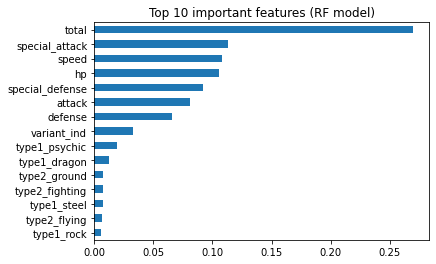

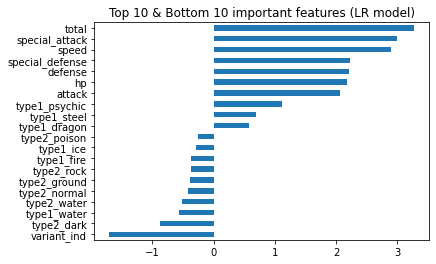

In [197]:
# data prep -- 

# NON-SMOTE: split data into random train and test subsets (75/25 split)
X_train, X_test, y_train, y_test = train_test_split(
                                        X, 
                                        y, 
                                        test_size = 0.25, 
                                        random_state = 37
                                    )

# model fitting --

# fit a random forest (rf) classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# fit a logistic regression (lr)
lr_model = LogisticRegression(solver='lbfgs')
lr_model.fit(X_train, y_train)

# feature importance --

# top 10 feature importance for each model
rf_importance = pd.Series(rf_model.feature_importances_, index=X.columns, name = 'rf_features')
lr_importance = pd.Series(lr_model.coef_[0], index=X.columns, name = 'lr_features')

# visualize top 10 in RF model
rf_importance.nlargest(15).sort_values(ascending = True).plot(kind='barh')
plt.title("Top 10 important features (RF model)")
plt.show()

# visualize top 10 positive, bottom 10 negative in LR model
lr_importance.nlargest(10).append(lr_importance.nsmallest(10)).sort_values(ascending = True).plot(kind='barh')
plt.title("Top 10 & Bottom 10 important features (LR model)")
plt.show()

In [198]:
# predictions --

# get prediction for rf model
rf_preds = rf_model.predict(X_test)
rf_preds2 = rf_model.predict_proba(X_test)
rf_preds2 = rf_preds2[:, 1] # keep probabilities for the positive outcome only

# get prediction for lr model
lr_preds = lr_model.predict(X_test)
lr_preds2 = lr_model.predict_proba(X_test)
lr_preds2 = lr_preds2[:, 1] # keep probabilities for the positive outcome only

# model evaluation --

# first, generate a no skill prediction (majority class... base rate = 50%)
ns_probs = [0 for _ in range(len(y_test))]

# area under curve (AUC)
ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, rf_preds2)
lr_auc = roc_auc_score(y_test, lr_preds2)

# precision & recall
rf_accuracy = accuracy_score(y_test, rf_preds)
rf_recall = recall_score(y_test, rf_preds)
rf_precision = precision_score(y_test, rf_preds)
lr_accuracy = accuracy_score(y_test, lr_preds)
lr_recall = recall_score(y_test, lr_preds)
lr_precision = precision_score(y_test, lr_preds)

# print results to console
#print('Baseline: ROC AUC = %.3f' % (ns_auc))
print('RF: ROC AUC = %.3f' % (rf_auc))
print('LR: ROC AUC = %.3f' % (lr_auc))

print(f'\nRF: Accuracy = {rf_accuracy:.2f}\nLR: Accuracy = {lr_accuracy:.2f}')
print(f'\nRF: Precision = {rf_precision:.2f}\nLR: Precision = {lr_precision:.2f}')
print(f'\nRF: Recall = {rf_recall:.2f}\nLR: Recall = {lr_recall:.2f}\n')


# plot the RF confusion matrix
#rf_cm = confusion_matrix(y_test, rf_preds)
#plt.figure(figsize=(8, 6))
#plt.title('RF: Confusion Matrix (with SMOTE)', size=16)
#sns.heatmap(rf_cm, annot=True, cmap='Blues')

RF: ROC AUC = 0.947
LR: ROC AUC = 0.944

RF: Accuracy = 0.97
LR: Accuracy = 0.91

RF: Precision = 0.96
LR: Precision = 0.92

RF: Recall = 0.79
LR: Recall = 0.35



## 4.2 SMOTE version
* **Model 1**: RF model
* **Model 2**: Logistic Regression model
* **Feature importance**: a quick look
* **Evaluation**: ROC-AUC, Precision & Recall

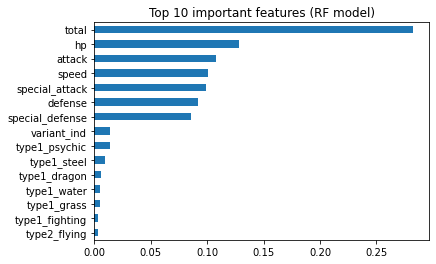

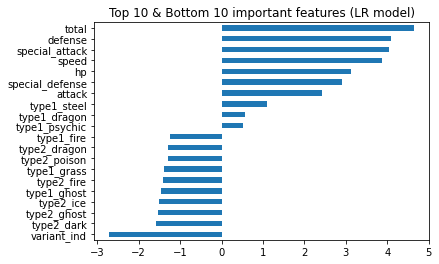

In [202]:
# data prep --

# SMOTE: apply SMOTE then split data into random train and test subsets (75/25 split)
sm = SMOTE(random_state = 42)
X_sm, y_sm = sm.fit_resample(X, y)

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(
                                        X_sm, 
                                        y_sm, 
                                        test_size = 0.25, 
                                        random_state = 42
                                    )

# model fitting --

# fit a random forest (rf) classifier
rf_sm_model = RandomForestClassifier(random_state = 42)
rf_sm_model.fit(X_train_sm, y_train_sm)

# fit a logistic regression (lr)
lr_sm_model = LogisticRegression(solver='lbfgs')
lr_sm_model.fit(X_train_sm, y_train_sm)

# feature importance --

# top 10 feature importance for each model
rf_sm_importance = pd.Series(rf_sm_model.feature_importances_, index=X_sm.columns, name = 'rf_features')
lr_sm_importance = pd.Series(lr_sm_model.coef_[0], index=X_sm.columns, name = 'lr_features')

# visualize top 10 in RF model
rf_sm_importance.nlargest(15).sort_values(ascending = True).plot(kind='barh')
plt.title("Top 10 important features (RF model)")
plt.show()

# visualize top 10 positive, bottom 10 negative in LR model
lr_sm_importance.nlargest(10).append(lr_sm_importance.nsmallest(10)).sort_values(ascending = True).plot(kind='barh')
plt.title("Top 10 & Bottom 10 important features (LR model)")
plt.show()

RF: ROC AUC = 0.996
LR: ROC AUC = 0.976

RF: Accuracy = 0.98
LR: Accuracy = 0.93

RF: Precision = 0.98
LR: Precision = 0.95

RF: Recall = 0.97
LR: Recall = 0.91



Text(0.5, 1.0, 'RF: ROC-AUC Curve (with SMOTE)')

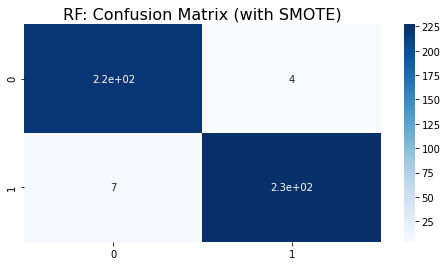

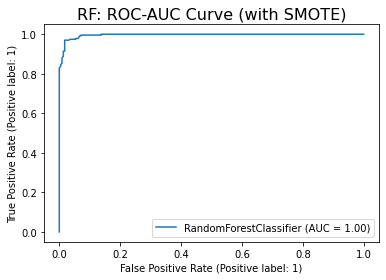

In [203]:
# predictions --

# get prediction for rf model
rf_preds = rf_sm_model.predict(X_test_sm)
rf_preds2 = rf_sm_model.predict_proba(X_test_sm)
rf_preds2 = rf_preds2[:, 1] # keep probabilities for the positive outcome only

# get prediction for lr model
lr_preds = lr_sm_model.predict(X_test_sm)
lr_preds2 = lr_sm_model.predict_proba(X_test_sm)
lr_preds2 = lr_preds2[:, 1] # keep probabilities for the positive outcome only

# model evaluation --

# first, generate a no skill prediction (majority class... base rate = 50%)
ns_probs = [0 for _ in range(len(y_test))]

# area under curve (AUC)
ns_auc = roc_auc_score(y_test_sm, ns_probs)
rf_auc = roc_auc_score(y_test_sm, rf_preds2)
lr_auc = roc_auc_score(y_test_sm, lr_preds2)

# accuracy, precision & recall
rf_accuracy = accuracy_score(y_test_sm, rf_preds)
rf_recall = recall_score(y_test_sm, rf_preds)
rf_precision = precision_score(y_test_sm, rf_preds)
lr_accuracy = accuracy_score(y_test_sm, lr_preds)
lr_recall = recall_score(y_test_sm, lr_preds)
lr_precision = precision_score(y_test_sm, lr_preds)

# print results to console
#print('Baseline: ROC AUC = %.3f' % (ns_auc))
print('RF: ROC AUC = %.3f' % (rf_auc))
print('LR: ROC AUC = %.3f' % (lr_auc))

print(f'\nRF: Accuracy = {rf_accuracy:.2f}\nLR: Accuracy = {lr_accuracy:.2f}')
print(f'\nRF: Precision = {rf_precision:.2f}\nLR: Precision = {lr_precision:.2f}')
print(f'\nRF: Recall = {rf_recall:.2f}\nLR: Recall = {lr_recall:.2f}\n')

# plot the RF confusion matrix
rf_cm = confusion_matrix(y_test_sm, rf_preds)
plt.figure(figsize=(8, 4))
plt.title('RF: Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(rf_cm, annot=True, cmap='Blues')

# plot the AUC-ROC curve
metrics.plot_roc_curve(rf_sm_model, X_test_sm, y_test_sm) 
plt.title('RF: ROC-AUC Curve (with SMOTE)', size=16)

In [204]:
# Trying out cross-validation for model evaluation here (RF model only)

# get AUC, Recall & Accuracy
rf_sm_cv_auc = cross_val_score(rf_sm_model, X_sm, y_sm, cv=10, scoring='roc_auc')
rf_sm_cv_precision = cross_val_score(rf_sm_model, X_sm, y_sm, cv=10, scoring='precision')
rf_sm_cv_recall = cross_val_score(rf_sm_model, X_sm, y_sm, cv=10, scoring='recall')
rf_sm_cv_accuracy = cross_val_score(rf_sm_model, X_sm, y_sm, cv=10, scoring='accuracy')
rf_sm_cv_f1score = cross_val_score(rf_sm_model, X_sm, y_sm, cv=10, scoring='f1')

# print results
print(f'RF: ROC AUC = {np.mean(rf_sm_cv_auc):.2f}')
print(f'RF: Accuracy = {np.mean(rf_sm_cv_accuracy):.2f}')
print(f'RF: Precision = {np.mean(rf_sm_cv_precision):.2f}')
print(f'RF: Recall = {np.mean(rf_sm_cv_recall):.2f}')
print(f'RF: F1 Score = {np.mean(rf_sm_cv_f1score):.2f}')

RF: ROC AUC = 0.99
RF: Accuracy = 0.97
RF: Precision = 0.96
RF: Recall = 0.97
RF: F1 Score = 0.97
